In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= 'Malgun Gothic')
import warnings
warnings.filterwarnings('ignore')

## [채무 상환 데이터]
대출자의 채무 상환 여부를 예측하기 위한 서포트 벡터 머신 분석을 실시하고 결과를 해석하시오.

### 1. 데이터 구성하기

In [3]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [4]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [5]:
#JOB 변수의 결측치는 other 로 대체
df_raw['JOB'].fillna('Other', inplace = True) #fillna 함수 적용 후 df_raw 데이터에 저장 : inplace = True

#숫자형 변수의 결측치는 평균값 입력
df_raw.fillna(df_raw.mean(), inplace=True)

In [6]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [7]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [8]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['BAD']
df_raw_x = df_raw_dummy.drop('BAD',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


### 2. 모델 생성

In [9]:
#기본 모델 생성
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set:{:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(svm_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.903


In [10]:
svm_uncustomized

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
##svc 모델 parameter 변경
#C : 규제에 대한 강도 변경

#train/ test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_c = [10** c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state=1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c['C'] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c['TestAccuracy'] = test_accuracy

In [12]:
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.91,0.903
1,0.10,0.91,0.903
2,1.00,1.00,0.903
3,10.00,1.00,0.903


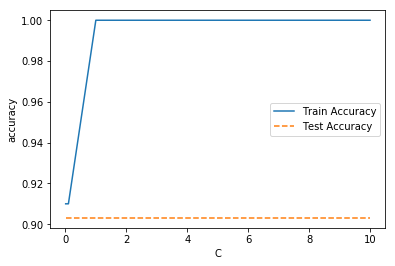

In [13]:
plt.plot(para_c, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_c, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

C가 1이상일 경우 train 정확도는 1(과대적합) test정확도는 변화 없음.

0.1로 지정

In [14]:
C=0.1

In [15]:
#Gamma : 훈련 샘플이 미치는 영향의 범위를 변경

#train/ test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_gamma = [10** gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, random_state=1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma['gamma'] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma['TestAccuracy'] = test_accuracy

In [16]:
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,1.0,0.903
1,0.10,1.0,0.903
2,1.00,1.0,0.903
3,10.00,1.0,0.903


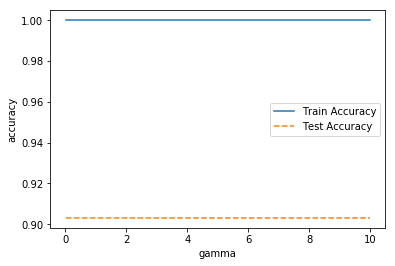

In [17]:
plt.plot(para_gamma, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_gamma, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

gamma 의 변화가 정확도에 영향을 미치지 않음

In [18]:
#scale 변환 : standardscaler : 설명변수 값의 구간을 동일하게 변경

v_feature_name = df_train_x.columns

scaler =StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [19]:
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size=0.3, random_state=1234)
print('train data X size: {}'.format(df_scaled_train_x.shape))
print('test data X size: {}'.format(df_scaled_test_x.shape))

train data X size: (2623, 18)
test data X size: (1125, 18)


In [25]:
#scale 조절 후 SVC 모델 재실행 : scale이 조정된 데이터로 새로운 모델 생성
svm_scaled =SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
print("Accuracy on training set:{:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(svm_scaled.score(df_scaled_test_x,df_test_y)))

Accuracy on training set:0.910
Accuracy on test set:0.903


In [26]:
#C규제에 대한 강도 변경
#train/ test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_c = [10** c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state=1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c['C'] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c['TestAccuracy'] = test_accuracy

In [27]:
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.910,0.903
1,0.10,0.910,0.903
2,1.00,0.910,0.903
3,10.00,0.915,0.901


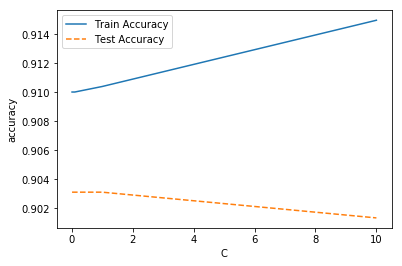

In [28]:
plt.plot(para_c, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_c, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

In [29]:
#Gamma : 훈련 샘플이 미치는 영향의 범위를 변경
train_accuracy=[]; test_accuracy=[]

para_gamma = [10**gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm=SVC(gamma=v_gamma, C=1, random_state=1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma['gamma'] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma['TestAccuracy'] = test_accuracy

In [30]:
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.910,0.903
1,0.10,0.911,0.903
2,1.00,0.921,0.900
3,10.00,0.946,0.901


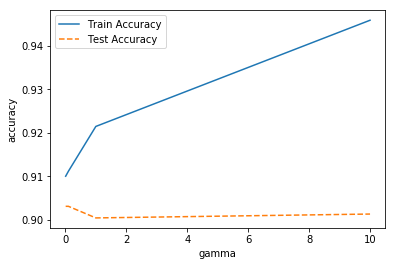

In [32]:
plt.plot(para_gamma, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_gamma, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

gamma = 0.1
### 3. 결론 도출

In [34]:
svc_final = SVC(gamma = 0.1, C=1, random_state=1234)
svc_final.fit(df_scaled_train_x, df_train_y)

y_pred = svc_final.predict(df_scaled_test_x)

print("Accuracy on training set:{:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(svc_final.score(df_scaled_test_x,df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set:0.911
Accuracy on test set:0.903
Confusion matrix:
[[1016    0]
 [ 109    0]]


In [35]:
#GridSearchCv를 이용한 최적 parameter 찾기

estimator = SVC(random_state=1234)

param_grid = {'C': para_c, "gamma": para_gamma}

grid_rf = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_rf.fit(df_scaled_train_x, df_train_y)
print('best estimator model:\n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_rf.best_params_))
print('nbest score:\n{}'.format(grid_rf.best_score_.round(3)))

best estimator model:
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)

best parameter:
{'C': 0.01, 'gamma': 0.01}
nbest score:
0.91


## [실습] 통신회사의 고객 이탈 데이터
고객의 이탈 여부를 예측하기 위한 서포트 벡터 머신 분석을 실시하고 결과를 해석하시오.
### 1. 데이터 구성하기

In [36]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2/통신고객이탈.csv")
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [37]:
df_raw.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [38]:
#명목형 변수 목록
obj_cols = df_raw.select_dtypes('object').columns
for col in obj_cols :
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

CHURN : 2
CUSTOMER_ID : 930
GENDER : 2
CHARGE_TYPE : 5
HANDSET : 11
USAGE_BAND : 6


In [39]:
df_raw['CHURN'] = np.where(df_raw['CHURN'] == 'Active',0,1)
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [40]:
df_raw['CHURN'].value_counts()

0    750
1    180
Name: CHURN, dtype: int64

In [41]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,0,31,33.33,6,218,379.8,9,21.6,366,632.4,...,0,0,0,0,0,0,1,0,0,0
1,0,27,30.87,10,373,656.4,11,28.0,411,810.4,...,0,0,0,0,0,0,1,0,0,0
2,0,27,49.40,11,260,582.0,0,0.0,265,614.1,...,0,0,0,0,0,0,1,0,0,0
3,0,61,48.60,1,294,661.8,14,101.5,326,844.0,...,0,0,0,0,0,0,1,0,0,0
4,0,52,56.03,0,221,555.6,7,25.0,274,673.0,...,0,0,0,0,0,0,1,0,0,0


In [42]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['CHURN']
df_raw_x = df_raw_dummy.drop('CHURN',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (651, 963)
train data Y size : (651,)
test data X size : (279, 963)
test data Y size : (279,)
